### Imports

In [15]:
import pandas as pd
import re
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [16]:
# Loading the dataset from a csv-file by using the relative path 
path = "../../../data/results.csv"
df = pd.read_csv(path)

In [17]:
# Converting values in the "date" column to datetime objects
df["date"] = pd.to_datetime(df["date"])
# Removing any possible rows with missing values
df.dropna(inplace=True)

The dataset used will be the FIFA Games between 2018, from after the 2018 World Cup to the last games before the 2022 World Cup. The idea is to analyze just the games played at the preparation and classification to WC.

In [18]:
# Sorting values by the "date" column and showing the last 5 rows (the tail)
df.sort_values("date").tail()
# Only matches since AFTER the world cup 2018 - so start of August 
df = df[(df["date"] >= "2018-8-1")].reset_index(drop=True)
# Sorting values again, showing the tail
df.sort_values("date").tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
5102,2024-02-07,Ivory Coast,DR Congo,1,0,African Cup of Nations,Ebimpé,Ivory Coast,False
5103,2024-02-07,Nigeria,South Africa,1,1,African Cup of Nations,Bouaké,Ivory Coast,True
5105,2024-02-10,South Africa,DR Congo,0,0,African Cup of Nations,Abidjan,Ivory Coast,True
5104,2024-02-10,Qatar,Jordan,3,1,AFC Asian Cup,Lusail,Qatar,False
5106,2024-02-11,Ivory Coast,Nigeria,2,1,African Cup of Nations,Ebimpé,Ivory Coast,False


Download 2nd Dataset, the Fifa World Cup Rankings

In [19]:
rank = pd.read_csv("fifa_ranking-2023-07-20.csv")

In [20]:
# We are doing with the 2nd dataphrame same as above: convert the date column to datetime object
# ...and filtering for matches since after the World Cup 2018
rank["rank_date"] = pd.to_datetime(rank["rank_date"])
rank = rank[(rank["rank_date"] >= "2018-8-1")].reset_index(drop=True)

In [21]:
rank.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,108,Central African Republic,CTA,1196.0,1196.0,0,CAF,2018-08-16
1,206,Bahamas,BAH,868.0,868.0,0,CONCACAF,2018-08-16
2,75,China PR,CHN,1320.0,1320.0,0,AFC,2018-08-16
3,74,South Africa,RSA,1327.0,1324.0,0,CAF,2018-08-16
4,73,Syria,SYR,1328.0,1328.0,0,AFC,2018-08-16


In [22]:
# To understand how this dataset works, let's filter for Germany matches
germany_matches = rank[rank['country_full'] == 'Germany']
germany_matches


,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
62,15,Germany,GER,1561.00,1600.00,14,UEFA,2018-08-16
349,12,Germany,GER,1568.00,1561.00,-3,UEFA,2018-09-20
566,14,Germany,GER,1555.00,1568.00,2,UEFA,2018-10-25
782,16,Germany,GER,1558.00,1555.00,2,UEFA,2018-11-29
902,16,Germany,GER,1558.00,1558.00,0,UEFA,2018-12-20
1055,16,Germany,GER,1558.00,1558.00,0,UEFA,2019-02-07
1405,13,Germany,GER,1570.00,1558.00,-3,UEFA,2019-04-04
1557,11,Germany,GER,1582.00,1570.00,-2,UEFA,2019-06-14
1839,15,Germany,GER,1582.00,1582.00,4,UEFA,2019-07-25
1958,16,Germany,GER,1580.00,1582.00,1,UEFA,2019-09-19


So this is how the Fifa rankings work
- FIFA World Rankings are typically updated on a monthly basis
- rank - country rank at time of publication
- rank_change: positive figure is ranking has dropped, negative figure means ranking has risen - because ranking 1 is the best, 10 is worse than that, so change of say -5 means you climb from rank 10 to 5
- rank_date: date of publication of the ranking



Some teams in the World Cup have different names in the ranking's dataset. We are fixing that. 

In [23]:
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States")

Now we merge the two

In [24]:
# setting the index to the rank_date column
# groups the DataFrame by the values in the "country_full" column
# .resample('D').first(): this resamples the data, converting it into daily frequency ('D') and taking the first value of each group. 
# This operation effectively fills in missing dates within each group (country), ensuring that there is a row for every day in the dataset, and using the first available rank for each country on each day.
# .fillna(method='ffill'): This fills in missing values (NaNs) using forward fill method (ffill). 
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

Overall, the above is used to ensure that the DataFrame rank contains a row for every day for each country, with missing rank values filled in using the last valid rank value available for each country.

In [25]:
df_wc_ranked = df.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)

df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)

Example frame just for Brazil matches

In [26]:
df_wc_ranked[(df_wc_ranked.home_team == "Brazil") | (df_wc_ranked.away_team == "Brazil")].tail(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
3265,2022-09-23,Brazil,Ghana,3,0,Friendly,Le Havre,France,True,1837.56,1837.56,1.0,0.0,1393.47,1389.68,60.0,0.0
3333,2022-09-27,Brazil,Tunisia,5,1,Friendly,Paris,France,True,1837.56,1837.56,1.0,0.0,1507.86,1507.86,30.0,0.0
3468,2022-11-24,Brazil,Serbia,2,0,FIFA World Cup,Lusail,Qatar,True,1841.30,1837.56,1.0,0.0,1563.62,1549.53,21.0,-4.0
3484,2022-11-28,Brazil,Switzerland,1,0,FIFA World Cup,Doha,Qatar,True,1841.30,1837.56,1.0,0.0,1635.92,1621.43,15.0,-1.0
3500,2022-12-02,Cameroon,Brazil,1,0,FIFA World Cup,Lusail,Qatar,True,1471.44,1484.95,43.0,5.0,1841.30,1837.56,1.0,0.0
3508,2022-12-05,Brazil,South Korea,4,1,FIFA World Cup,Doha,Qatar,True,1841.30,1837.56,1.0,0.0,1530.30,1526.02,28.0,0.0
3511,2022-12-09,Croatia,Brazil,1,1,FIFA World Cup,Al Rayyan,Qatar,True,1645.64,1632.15,12.0,-3.0,1841.30,1837.56,1.0,0.0
3621,2023-03-25,Morocco,Brazil,2,1,Friendly,Tangier,Morocco,False,1672.35,1563.50,11.0,-11.0,1840.77,1841.30,1.0,0.0
3764,2023-06-17,Brazil,Guinea,4,1,Friendly,Barcelona,Spain,True,1834.21,1840.77,3.0,2.0,1305.92,1290.47,79.0,-4.0
3817,2023-06-20,Brazil,Senegal,2,4,Friendly,Lisbon,Portugal,True,1834.21,1840.77,3.0,2.0,1613.21,1603.98,18.0,-1.0


### Features Engineering
The idea here is to create possible features that have impact on predicting football games. 

- As a first step, we create a feature that says which team won and how much points they won for each game
- 3 points for a win, 1 for a draw, 0 for a loss

In [27]:
df = df_wc_ranked

We build a function that returns a pandas series 
- [0 3 0] means 0 for home team win, 3 points for home team, 0 points for away team
- [1 0 3] means 1 for away team win, 0 points for home team, 3 points for away team
- [2 1 1] means 2 for draw, 1 point for home team, 1 point for away team

In [28]:
def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

results = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)

We add these 3 extra columns to our dataframe 

In [29]:
results.head()
df[["result", "home_team_points", "away_team_points"]] = results

In [30]:
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away,result,home_team_points,away_team_points
0,2018-08-18,Andorra,United Arab Emirates,0,0,Friendly,Grödig,Austria,True,1120.0,1120.0,130.0,0.0,1312.0,1312.0,77.0,0.0,2,1,1
1,2018-08-18,Grenada,Jamaica,1,5,Friendly,St. George's,Grenada,False,980.0,980.0,168.0,0.0,1400.0,1400.0,54.0,0.0,1,0,3
2,2018-08-18,Guatemala,Cuba,1,0,Friendly,Quetzaltenango,Guatemala,False,1064.0,1064.0,146.0,0.0,940.0,940.0,181.0,0.0,0,3,0
3,2018-08-20,Barbados,Jamaica,2,2,Friendly,Bridgetown,Barbados,False,1005.0,1008.0,160.0,0.0,1400.0,1400.0,54.0,0.0,2,1,1
4,2018-08-26,Barbados,Cuba,0,0,Friendly,Bridgetown,Barbados,False,1005.0,1008.0,160.0,0.0,940.0,940.0,181.0,0.0,2,1,1


Important:
- again, the game points are 3 for win, 1 for draw and 0 for lose 
- this is different from the FIFA rank points that are already in the database
- FIFA Rank points and FIFA Ranking of the same team are negative correlated (increase in points = ranking rises -> since 1 is the highest ranking more points ranking in numerial terms goes down), and we should use only one of them to create new features. 

Now, we create columns that will help in the creation of the features: 
- ranking difference
- goals difference in the game. 
- points won at the game vs. team faced rank for home team
- points won at the game vs. team faced rank for away team


In [37]:
# ranking difference of home and away team
df["rank_dif"] = df["rank_home"] - df["rank_away"]
# goal difference 
df["sg"] = df["home_score"] - df["away_score"]
# points won by the home team as a coefficient of the rank of the away team 
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"]
# points won by the away team as a coefficient of the rank of the home team 
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"]
# for the last two lines of code this means: the lower points_home_by_rank, the more valuable this is, since 1 is the highest ranking


In [50]:
home_team = df[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_dif", "points_home_by_rank", "home_team_points"]]

away_team = df[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_dif", "points_away_by_rank", "away_team_points"]]

In [51]:
home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]

away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

In [52]:
team_stats = pd.concat([home_team, away_team], ignore_index=True)
team_stats.tail()

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points
7753,2023-07-09,Jamaica,1,0,63.0,116.0,0.0,1367.83,1,53.0,0.025862,3
7754,2023-07-09,Canada,2,2,45.0,11.0,-2.0,1454.12,2,-34.0,0.090909,1
7755,2023-07-12,Panama,1,1,57.0,11.0,-1.0,1399.23,2,-46.0,0.090909,1
7756,2023-07-12,Mexico,3,0,14.0,63.0,-1.0,1639.19,1,49.0,0.047619,3
7757,2023-07-16,Panama,0,1,57.0,14.0,-1.0,1399.23,0,-43.0,0.000000,0


In [53]:
#this column will be used to calculate features for simulation
team_stats_raw = team_stats.copy()

Now, we have a database ready to create predictive features. 

In [54]:
stats_val = []

for index, row in team_stats.iterrows():
    team = row["team"]
    date = row["date"]
    past_games = team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date)].sort_values(by=['date'], ascending=False)
    last5 = past_games.head(5)
    
    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()
    
    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()
    
    rank = past_games["rank_suf"].mean()
    rank_l5 = last5["rank_suf"].mean()
    
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]#qtd de pontos ganhos
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1] 
    else:
        points = 0
        points_l5 = 0
        
    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()
    
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()
    
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5])

The features are: 



- Mean goals of the team in World Cup Cycle.
- Mean goals of the team in last 5 games.
- Mean goals suffered of the team in World Cup Cycle.
- Mean goals suffered of the team in last 5 games.
- Mean FIFA Rank that team faced in World Cup Cycle.
- Mean FIFA Rank that team faced in last 5 games.
- FIFA Points won at the cycle.
- FIFA Points won in last 5 games.
- Mean game points at the Cycle.
- Mean game points at last 5 games.
- Mean game points by rank faced at the Cycle.
- Mean game points by rank faced at last 5 games.

In [55]:
stats_cols 
= ["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", "points_mean", "points_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5"]

stats_df = pd.DataFrame(stats_val, columns=stats_cols)

full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

SyntaxError: invalid syntax (90886226.py, line 2)

In [56]:
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

the new columns are: 

In [57]:
home_team_stats.columns[-12:]

Index(['goals_mean', 'goals_mean_l5', 'goals_suf_mean', 'goals_suf_mean_l5',
       'rank_mean', 'rank_mean_l5', 'points_mean', 'points_mean_l5',
       'game_points_mean', 'game_points_mean_l5', 'game_points_rank_mean',
       'game_points_rank_mean_l5'],
      dtype='object')

In [58]:
home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]

In [59]:
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

In order to unify the database, is needed to add home and away suffix for each column. After that, the data is ready to be merged.

In [60]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [61]:
full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [62]:
full_df.columns


Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

Now, to quantify game importance, we create a column that shows whether its a friendly match or a competition match. 
Friendly == 1
Competitive match == 0

In [29]:
def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x)) 

In [30]:
full_df = pd.get_dummies(full_df, columns=["is_friendly"])

In [31]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

And, after that, we select only columns that will help in Features' analysis.

In [32]:
base_df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_dif", "rank_change_home", "rank_change_away", 'home_goals_mean',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5','away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5',
       'is_friendly_0', 'is_friendly_1']]

base_df.tail()

,date,home_team,away_team,rank_home,rank_away,home_score,away_score,result,rank_dif,rank_change_home,...,home_game_points_mean,home_game_points_mean_l5,home_game_points_rank_mean,home_game_points_rank_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5,is_friendly_0,is_friendly_1
3874,2023-07-09,Guatemala,Jamaica,116.0,63.0,0,1,1,53.0,0.0,...,1.729167,1.4,0.018088,0.023465,1.269231,1.0,0.020674,0.034487,1,0
3875,2023-07-09,United States,Canada,11.0,45.0,2,2,2,-34.0,-2.0,...,1.904110,2.2,0.055824,0.075214,1.920000,2.0,0.040238,0.023091,1,0
3876,2023-07-12,United States,Panama,11.0,57.0,1,1,2,-46.0,-2.0,...,1.891892,2.2,0.055370,0.066326,1.317460,1.4,0.030376,0.028361,1,0
3877,2023-07-12,Jamaica,Mexico,63.0,14.0,0,3,1,49.0,0.0,...,1.301887,1.4,0.020772,0.026326,1.876543,2.4,0.041127,0.039027,1,0
3878,2023-07-16,Mexico,Panama,14.0,57.0,1,0,0,-43.0,-1.0,...,1.890244,2.4,0.041206,0.038206,1.312500,1.6,0.031322,0.046543,1,0


In [33]:
base_df.shape

(3879, 37)

In [34]:
base_df.isna().sum()

date                               0
home_team                          0
away_team                          0
rank_home                          0
rank_away                          0
home_score                         0
away_score                         0
result                             0
rank_dif                           0
rank_change_home                   0
rank_change_away                   0
home_goals_mean                   99
home_goals_mean_l5                99
home_goals_suf_mean               99
home_goals_suf_mean_l5            99
home_rank_mean                    99
home_rank_mean_l5                 99
home_points_mean                   0
home_points_mean_l5                0
away_goals_mean                  101
away_goals_mean_l5               101
away_goals_suf_mean              101
away_goals_suf_mean_l5           101
away_rank_mean                   101
away_rank_mean_l5                101
away_points_mean                   0
away_points_mean_l5                0
h

The games with NA are the ones who mean could not be calculated (games from the beginning of the dataset). Those will be dropped.

In [35]:
base_df_no_fg = base_df.dropna()

In [36]:
base_df_no_fg.shape

(3751, 37)

### Data Analysis

Now, we need to analyze all features that were created and check if they have predictive power. Also, if they don't have, we need to create some that have, like differences of home and away teams. To analyze the predictive power, I'll assign draw games as a lose of the home team and will create a binary problem.

In [37]:
df = base_df_no_fg

In [38]:
def no_draw(x):
    if x == 2:
        return 1
    else:
        return x
    
df["target"] = df["result"].apply(lambda x: no_draw(x))

/tmp/ipykernel_1100/1906038641.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"] = df["result"].apply(lambda x: no_draw(x))


In [39]:
data1 = df[list(df.columns[8:20].values) + ["target"]]
data2 = df[df.columns[20:]]

In [40]:
scaled = (data1[:-1] - data1[:-1].mean()) / data1[:-1].std()
scaled["target"] = data1["target"]
violin1 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

scaled = (data2[:-1] - data2[:-1].mean()) / data2[:-1].std()
scaled["target"] = data2["target"]
violin2 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

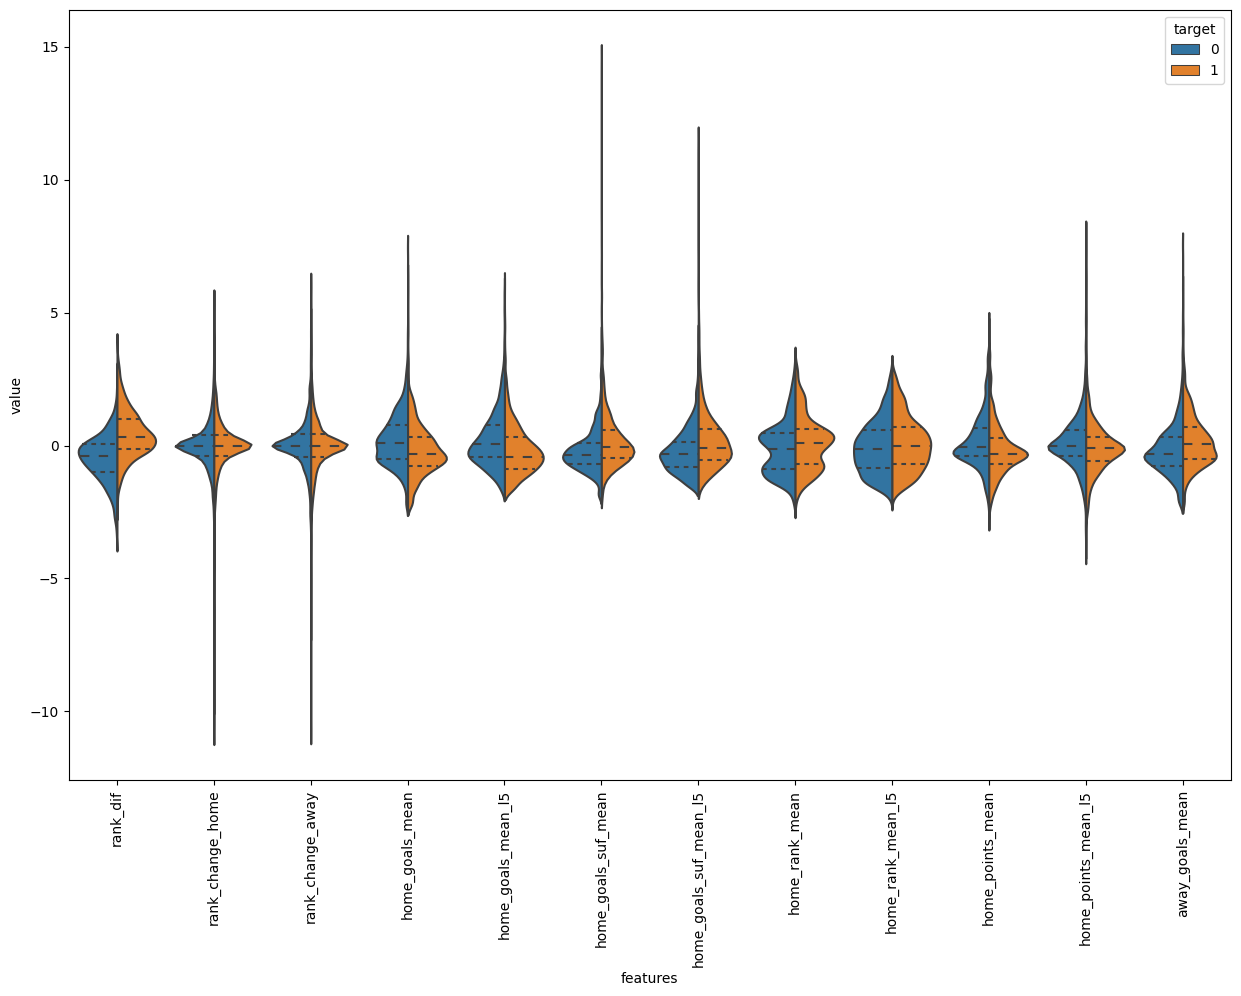

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin1,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

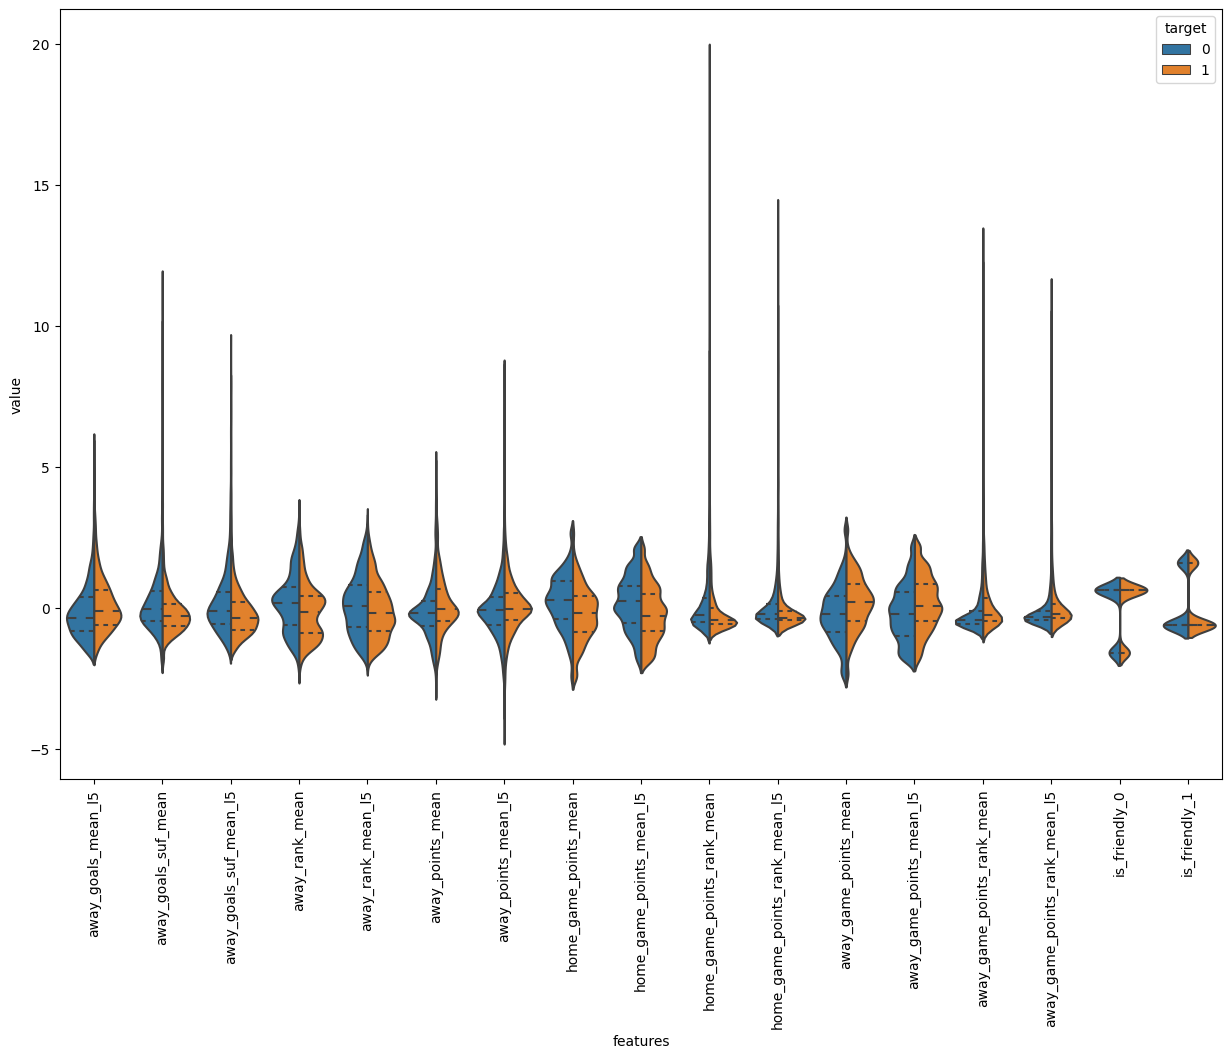

In [42]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin2,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

With the plots, we find that rank difference is the only good separator of the data. But, we can create features that get the differences between home and away team and analyze if they are good separating the data.

In [43]:
df.columns
print(df.columns)
df.head()

Index(['date', 'home_team', 'away_team', 'rank_home', 'rank_away',
       'home_score', 'away_score', 'result', 'rank_dif', 'rank_change_home',
       'rank_change_away', 'home_goals_mean', 'home_goals_mean_l5',
       'home_goals_suf_mean', 'home_goals_suf_mean_l5', 'home_rank_mean',
       'home_rank_mean_l5', 'home_points_mean', 'home_points_mean_l5',
       'away_goals_mean', 'away_goals_mean_l5', 'away_goals_suf_mean',
       'away_goals_suf_mean_l5', 'away_rank_mean', 'away_rank_mean_l5',
       'away_points_mean', 'away_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5', 'is_friendly_0', 'is_friendly_1',
       'target'],
      dtype='object')


,date,home_team,away_team,rank_home,rank_away,home_score,away_score,result,rank_dif,rank_change_home,...,home_game_points_mean_l5,home_game_points_rank_mean,home_game_points_rank_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5,is_friendly_0,is_friendly_1,target
4,2018-08-26,Barbados,Cuba,160.0,181.0,0,0,2,-21.0,0.0,...,1.0,0.018519,0.018519,0.0,0.0,0.000000,0.000000,0,1,1
6,2018-08-29,Barbados,Cuba,160.0,181.0,0,2,1,-21.0,0.0,...,1.0,0.012022,0.012022,0.5,0.5,0.003125,0.003125,0,1,1
31,2018-09-06,Mongolia,Guam,186.0,190.0,1,1,2,-4.0,0.0,...,3.0,0.016216,0.016216,0.0,0.0,0.000000,0.000000,1,0,1
32,2018-09-06,Nepal,Bhutan,161.0,183.0,4,0,0,-22.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1,0,0
33,2018-09-06,Bangladesh,Pakistan,194.0,201.0,1,0,0,-7.0,0.0,...,1.5,0.008197,0.008197,3.0,3.0,0.018634,0.018634,1,0,0


In [44]:
dif = df.copy()
dif.loc[:, "goals_dif"] = dif["home_goals_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_mean_l5"]
dif.loc[:, "goals_suf_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_suf_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_made_suf_dif"] = dif["home_goals_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_made_suf_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_suf_made_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_suf_made_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_mean_l5"]

In [45]:
dif.loc[:, "dif_points"] = dif["home_game_points_mean"] - dif["away_game_points_mean"]
dif.loc[:, "dif_points_l5"] = dif["home_game_points_mean_l5"] - dif["away_game_points_mean_l5"]
dif.loc[:, "dif_points_rank"] = dif["home_game_points_rank_mean"] - dif["away_game_points_rank_mean"]
dif.loc[:, "dif_points_rank_l5"] = dif["home_game_points_rank_mean_l5"] - dif["away_game_points_rank_mean_l5"]

In [46]:
dif.loc[:, "dif_rank_agst"] = dif["home_rank_mean"] - dif["away_rank_mean"]
dif.loc[:, "dif_rank_agst_l5"] = dif["home_rank_mean_l5"] - dif["away_rank_mean_l5"]

In [47]:
dif.loc[:, "goals_per_ranking_dif"] = (dif["home_goals_mean"] / dif["home_rank_mean"]) - (dif["away_goals_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif"] = (dif["home_goals_suf_mean"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_dif_l5"] = (dif["home_goals_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_mean_l5"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif_l5"] = (dif["home_goals_suf_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean_l5"] / dif["away_rank_mean"])

Features that we would want to use:

- Difference of points (full and last 5 games)
- difference of points by ranking faced (full and last 5 games)
- difference of rank faced (full and last 5 games) are good features

Also, some of the generated features have very similar distributions which will be analyzed using scatterplots.

For the differences of rank faced, game points by rank faced and mean game points by rank faced, the two versions (full and 5 games) are not so similar. So, we will use both.

Based on that, final features are:

- rank_dif
- goals_dif
- goals_dif_l5
- goals_suf_dif
- goals_suf_dif_l5
- dif_rank_agst
- dif_rank_agst_l5
- goals_per_ranking_dif
- dif_points_rank
- dif_points_rank_l5
- is_friendly

In [48]:
def create_db(df):
    columns = ["home_team", "away_team", "target", "rank_dif", "home_goals_mean", "home_rank_mean", "away_goals_mean", "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "away_game_points_rank_mean", "away_game_points_rank_mean_l5","is_friendly_0", "is_friendly_1"]
    
    base = df.loc[:, columns]
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]
    
    model_df = base[["home_team", "away_team", "target", "rank_dif", "goals_dif", "goals_dif_l5", "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", "dif_rank_agst", "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", "is_friendly_0", "is_friendly_1"]]
    return model_df

In [49]:
model_db = create_db(df)

In [50]:
model_db

,home_team,away_team,target,rank_dif,goals_dif,goals_dif_l5,goals_suf_dif,goals_suf_dif_l5,goals_per_ranking_dif,dif_rank_agst,dif_rank_agst_l5,dif_points_rank,dif_points_rank_l5,is_friendly_0,is_friendly_1
4,Barbados,Cuba,1,-21.0,2.000000,2.0,1.000000,1.0,0.037037,-92.000000,-92.0,0.018519,0.018519,0,1
6,Barbados,Cuba,1,-21.0,1.000000,1.0,0.500000,0.5,0.008511,-35.500000,-35.5,0.008897,0.008897,0,1
31,Mongolia,Guam,1,-4.0,4.000000,4.0,-1.000000,-1.0,0.021622,0.000000,0.0,0.016216,0.016216,1,0
32,Nepal,Bhutan,0,-22.0,1.000000,1.0,0.000000,0.0,0.004975,7.000000,7.0,0.000000,0.000000,1,0
33,Bangladesh,Pakistan,0,-7.0,-1.000000,-1.0,-0.500000,-0.5,-0.007200,30.500000,30.5,-0.010437,-0.010437,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3874,Guatemala,Jamaica,1,53.0,0.179487,-1.4,-0.392628,-1.2,-0.003900,33.016026,26.2,-0.002586,-0.011022,1,0
3875,United States,Canada,1,-34.0,-0.503288,0.6,-0.126575,-0.6,0.004568,-23.756438,-38.6,0.015587,0.052124,1,0
3876,United States,Panama,1,-46.0,0.481553,1.2,-0.721793,-0.6,0.013081,-8.859073,7.2,0.024994,0.037965,1,0
3877,Jamaica,Mexico,1,49.0,-0.245749,-0.4,0.338225,0.8,-0.012009,22.633124,10.6,-0.020355,-0.012701,1,0


In [52]:
model_db.shape

(3751, 15)